<a href="https://colab.research.google.com/github/aabs7/CNN-denoiser/blob/master/Code/Denoising/Speech_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import librosa
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import IPython.display as ipd
import librosa.display
import scipy
import glob
import os
import datetime
import librosa.display

# load the tensorboard notebook extension
%load_ext tensorboard

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17203361792719949293, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 404931296836627330
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
tf.random.set_seed(999)
np.random.seed(999)

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
! ls /content/drive/MyDrive/Dataset/records/

test_0.tfrecords   train_1.tfrecords  train_5.tfrecords  val_1.tfrecords
test_1.tfrecords   train_2.tfrecords  train_6.tfrecords  val_2.tfrecords
test_2.tfrecords   train_3.tfrecords  train_7.tfrecords  val_3.tfrecords
train_0.tfrecords  train_4.tfrecords  val_0.tfrecords


In [7]:
path_to_dataset = "/content/drive/MyDrive/Dataset/records/"

In [8]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset,'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset,'val_*'))

# shuffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names:",train_tfrecords_filenames)
print("Validation file names:", val_tfrecords_filenames)

Training file names: ['/content/drive/MyDrive/Dataset/records/train_3.tfrecords', '/content/drive/MyDrive/Dataset/records/train_2.tfrecords', '/content/drive/MyDrive/Dataset/records/train_6.tfrecords', '/content/drive/MyDrive/Dataset/records/train_7.tfrecords', '/content/drive/MyDrive/Dataset/records/train_1.tfrecords', '/content/drive/MyDrive/Dataset/records/train_5.tfrecords', '/content/drive/MyDrive/Dataset/records/train_4.tfrecords', '/content/drive/MyDrive/Dataset/records/train_0.tfrecords']
Validation file names: ['/content/drive/MyDrive/Dataset/records/val_0.tfrecords', '/content/drive/MyDrive/Dataset/records/val_1.tfrecords', '/content/drive/MyDrive/Dataset/records/val_2.tfrecords', '/content/drive/MyDrive/Dataset/records/val_3.tfrecords']


In [9]:
# Parameters about window and audio
windowLength = 256
overlap = round(0.25 * windowLength) #overlap of 75%
fftLength = windowLength
inputFs = 48e3
fs = 16e3
numFeatures = fftLength//2 + 1
numSegments = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",fftLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [10]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((),tf.string,default_value = ""),
        "noise_stft_mag_features": tf.io.FixedLenFeature([],tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((),tf.string)
    }
    
    features = tf.io.parse_single_example(record,keys_to_features)
    
    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'],tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'],tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'],tf.float32)
    
    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features,(129,8,1),name = "noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude,(129,1,1),name = "clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase,(129,),name = "noise_stft_phase")
    
    return noise_stft_mag_features,clean_stft_magnitude

In [11]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(buffer_size = 50)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [12]:
# explore dataset
print(train_dataset.take(1))

<TakeDataset shapes: ((None, 129, 8, 1), (None, 129, 1, 1)), types: (tf.float32, tf.float32)>


In [13]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(32)

# Model Training

In [14]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [ ]:
def build_model(l2_strength):
    inputs = Input(shape = [numFeatures,numSegments,1])
    x = inputs
    x = tf.keras.layers.ZeroPadding2D(((4,4),(0,0)))(x)
    
    # 1. -----------------------------------------------------------
    
    x = Conv2D(name = "I.Conv",
              filters = 18,
              kernel_size = [9,8],
              strides = [1,1],
              padding = 'valid',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    skip0 = Conv2D(name = "II.Conv.S",
                   filters = 30,
                   kernel_size = [5,1],
                   strides = [1,1],
                   padding = 'same',
                   use_bias = False,
                   kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
                  )(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "III.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 2. ----------------------------------------------------------
    
    x = Conv2D(name = "IV.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    skip1 = Conv2D(name = "V.Conv.S",
                   filters = 30,
                   kernel_size = [5,1],
                   strides = [1,1],
                   padding = 'same',
                   use_bias = False,
                   kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
                  )(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "VI.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 3. ----------------------------------------------------------
    
    x = Conv2D(name = "VII.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "VIII.Conv",
              filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "IX.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 4. ----------------------------------------------------------
    
    x = Conv2D(name = "X.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XI.Conv.ADD.V.Conv",
              filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    
    x = x + skip1
    
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XII.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 5. ----------------------------------------------------------
    
    x = Conv2D(name = "XIII.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XIV.Conv.ADD.II.Conv",
              filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    
    x = x + skip0
    
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XV.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    #----------------------------------------------------------
    
    
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(name = "XVI.Conv",
               filters = 1,
               kernel_size = [129,1],
               strides = [1,1],
               padding = 'same'
              )(x)
    
    model = Model(inputs = inputs, outputs = x)
    
    optimizer = tf.keras.optimizers.Adam(3e-4)
    
    model.compile(optimizer = optimizer,
                  loss = 'mse',
                  metrics = [tf.keras.metrics.RootMeanSquaredError('rmse')]
                 )
    
    return model   

In [ ]:
model = build_model(l2_strength = 0.0)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 137, 8, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
I.Conv (Conv2D)                 (None, 129, 1, 18)   1296        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 129, 1, 18)   0           I.Conv[0][0]                     
____________________________________________________________________________________________

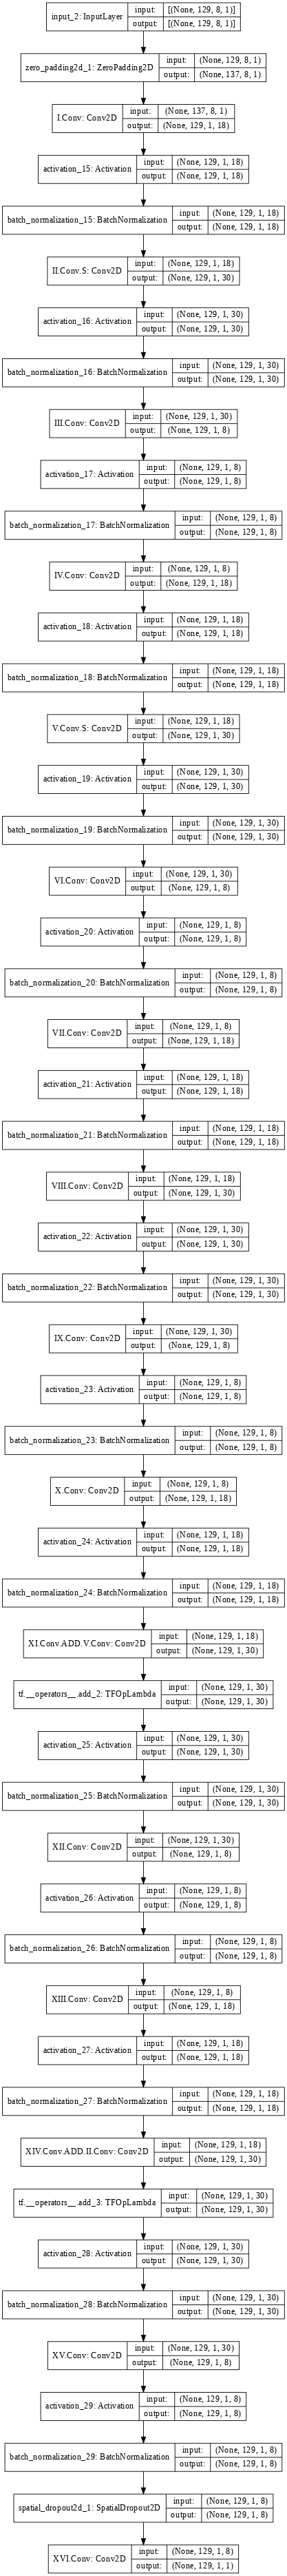

In [ ]:
tf.keras.utils.plot_model(model,show_shapes = True,dpi = 64)

In [ ]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 388), started 0:14:45 ago. (Use '!kill 388' to kill it.)

<IPython.core.display.Javascript object>

In [15]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised,cleaned,eps = 1e-7):
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [ ]:
!ls ./

'"'   drive   logs   model.png	 sample_data


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                          patience = 50,
                                                          restore_best_weights = True,
                                                          baseline = None)
logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,update_freq = 'batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Dataset/denoiser_cnn_log_mel_generator.h5',
                                                        monitor = 'val_loss',
                                                        save_best_only = True)

model.fit(train_dataset,
         steps_per_epoch = 50,
         validation_data = test_dataset,
         epochs = 1032,
         callbacks = [early_stopping_callback,tensorboard_callback,checkpoint_callback])

In [ ]:
cd ./

In [16]:
model = keras.models.load_model("/content/drive/MyDrive/Dataset/denoiser_cnn_log_mel_generator.h5")